In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()



In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
#PATH DEFINED
genuine_image_paths = "/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/real"
forged_image_paths = "/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/forged"

In [70]:
#PREPOCESSING THE IMAGE
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [71]:
import os
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


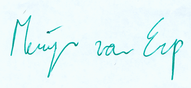

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/real/001001_000.png')
cv2_imshow(img)

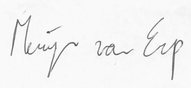

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)


In [ ]:
img.shape

(88, 191, 3)

In [ ]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [ ]:
greybin(img)

<ipython-input-52-402cb528bc70>:6: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (88, 191, 3) looks like that of an RGB image.
  thres = threshold_otsu(img)


array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [ ]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg


In [ ]:
#FEATURE EXTRACTION
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [ ]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]





In [ ]:
def EccentricitySolidity(img):
      r = regionprops(img.astype("int8"))
      return r[0].eccentricity, r[0].solidity

In [ ]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))

    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)
  #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)


In [ ]:
# Output
img = np.random.randint(0, 255, size=(100, 100))
(skewx, skewy), (kurtx, kurty) = SkewKurtosis(img)
print(f"Skewness: ({skewx:.3f}, {skewy:.3f})")
print(f"Kurtosis: ({kurtx:.3f}, {kurty:.3f})")

Skewness: (0.005, 0.007)
Kurtosis: (-1.216, -1.195)


In [ ]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [ ]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [ ]:
#SAVING THE FEATURES
def makeCSV():
    if not(os.path.exists('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features')):
        os.mkdir('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features')
        print('New folder "Features" created')
    if not(os.path.exists('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Training')):
        os.mkdir('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Testing')):
        os.mkdir('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,14):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)

        with open('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,3):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,3):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

        with open('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(3,5):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')
makeCSV()


Saving features for person id- 001
Saving features for person id- 002
Saving features for person id- 003
Saving features for person id- 004
Saving features for person id- 005
Saving features for person id- 006
Saving features for person id- 007
Saving features for person id- 008
Saving features for person id- 009
Saving features for person id- 010
Saving features for person id- 011
Saving features for person id- 012
Saving features for person id- 013


In [ ]:
#TF MODEL
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/TestFeatures')):
        os.mkdir('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/TestFeatures')
    with open('/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')




In [ ]:
 n_input = 9
train_person_id = input("Enter person's id : ")
test_image_path = input("Enter path of signature image : ")
train_path = '/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/Features/Training/training_'+train_person_id+'.csv'
testing(test_image_path)
test_path = '/content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/TestFeatures/testcsv.csv'

def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=(n_input,))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = kearas.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

ops.reset_default_graph()
# Parameters
learning_rate = 0.001
training_epochs = 1000
display_step = 1

# Network Parameters
n_hidden_1 = 7 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
n_hidden_3 = 30 # 3rd layer
n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=3)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes], seed=4))
}

# Create model
def multilayer_perceptron(x):
    layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    out_layer = tf.tanh(tf.matmul(layer_1, weights['out']) + biases['out'])
    return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer

loss_op = tf.reduce_mean(tf.squared_difference(logits, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# For accuracies
pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()

def evaluate(train_path, test_path, type2=False):
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    ans = 'Random'
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            if cost<0.0001:
                break
        #Display logs per epoch step
            if epoch % 999 == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
                print("Optimization Finished!")

        # Finding accuracies
        accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
        print("Accuracy for train:", accuracy1)
        #print("Accuracy for test:", accuracy2)
        if type2 is False:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
            return accuracy1, accuracy2
        else:
            prediction = pred.eval({X: test_input})
            if prediction[0][1]>prediction[0][0]:
                print('Genuine Image')
                return True
            else:
                print('Forged Image')
                return False
def trainAndTest(rate=0.001, epochs=1700, neurons=7, display=False):
    start = time()

    # Parameters
    global training_rate, training_epochs, n_hidden_1
    learning_rate = rate
    training_epochs = epochs

    # Network Parameters
    n_hidden_1 = neurons # 1st layer number of neurons
    n_hidden_2 = 7 # 2nd layer number of neurons
    n_hidden_3 = 30 # 3rd layer

    train_avg, test_avg = 0, 0
    n = 10
    for i in range(1,n+1):
        if display:
            print("Running for Person id",i)
        temp = ('0'+str(i))[-2:]
        train_score, test_score = evaluate(train_path.replace('01',temp), test_path.replace('01',temp))
        train_avg += train_score
        test_avg += test_score
    if display:
#         print("Number of neurons in Hidden layer-", n_hidden_1)
        print("Training average-", train_avg/n)
        print("Testing average-", test_avg/n)
        print("Time taken-", time()-start)
    return train_avg/n, test_avg/n, (time()-start)/n
evaluate(train_path, test_path, type2=True)

Enter person's id : 001
Enter path of signature image : /content/drive/MyDrive/Signature-Forgery-Detection-main - Copy/forged/021001_000.png
Epoch: 0001 cost=2.182047844
Optimization Finished!
Epoch: 1000 cost=0.019948592
Optimization Finished!
Accuracy for train: 1.0
Forged Image


False